# Comparing various machine learning models for music genre classification

## Abstract
To tackle the problem of classifying the musical genre of songs based on "carefully chosen features", approaches using **support vector machines (SVM), Random Forest, XGBoost, and deep neural networks** were used. Data analysis showed high class imbalance in the dataset, and visualizations such as the correlation matrix of features, 3-dimensional PCA projection, and feature-class plots, indicate that many of the features are either non-informative and that classes are not easily separable. The class imbalance was not addressed directly in our final approach, since the Kaggle test data is similarly imbalanced and attempts to balance the classes gave worse results on the validation dataset. **Feature scaling**, on the other hand, improved most of the models' performance. On the Kaggle dataset, the best variants of all models ranged from **60.2%-66.2% in accuracy and 0.236-0.171 in log-loss**, with XGBoost scoring the highest on both metrics.


## 1. Introduction

### Background and motivation
Music genre classification is a compelling problem to solve with a machine, for music
database management, recommendation systems in music streaming services, smart playlist generation, and many other applications.

The task of finding a good algorithm to classify music genre is more difficult than it would appear at first glance. Human perception of "natural" phenomenon, like images and sound, is non-trivial with an algorithm. The most popular approaches for music genre classification are with supervised machine learning, such as Bayesian methods [3], nearest neighbour methods [1, 3], decision trees [3],  Support Vector Machines [1, 3], and neural networks [1, 3], including recurrent neural networks [5] and convolutional neural networks (CNNs) [6].

There are many ways to represent music as data, such as Mel-frequency cepstral coefficients (MFCCs), spectral contrast and spectral roll-off [7]. Another common representation is the spectrogram of a signal. Spectrograms can even be considered as images and used to train CNNs [6].

### Problem statement
 - Given $X$, data matrix of 4363 data points and 264 features ($X\in\mathbb{R}^{4363,264}$) and labels $y\in\mathbb{R}^{4363}$ with each $y_i \in \{1, 2, ... , 10\} $
 - Each row $x_i$ in $X$ represents a feature vector of song $i$
 - Each number $y_i$ represents the music genre of song $i$

The task is to find an algorithm that given a set of similar features $\hat{X}$ disjoint from the training set $X$, correctly predicts its music genre.

### Overview of approach
Data analysis showed that the training data $X$ is higly imbalanced. Visualization of the feature values confirmed the need for scaling.

The focus of this project is evaluating a good selection of models, especially those with in-built feature selection mechanisms, rather than on manual feature engineering. Efforts in balancing classes did not yield better results, sometimes even giving worse results, since **the public test dataset on Kaggle is imbalanced as well, with 51.0% labeled as pop rock**. 

Our approach is to try a variety of simpler models with fewer parameters, the most complex being the 2- and 3-layer neural networks.

Each model variant is evaluated "offline" on a held-out validation set split from 30% of $X$ as well as with cross-validation on all of $X$, as well as with "online" Kaggle accuracies and log-losses.

## 2. Data analysis
The class distribution is **heavily imbalanced** towards "Pop Rock", which makes up 49.9% of the labels in the training set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

# Read data
train_data_df = pd.read_csv("data/train_data.csv", header=None)
test_data_df = pd.read_csv("data/test_data.csv", header=None)
all_data_df = train_data_df.append(test_data_df)
train_labels_df = pd.read_csv("data/train_labels.csv", header=None, 
                              names=['class'])

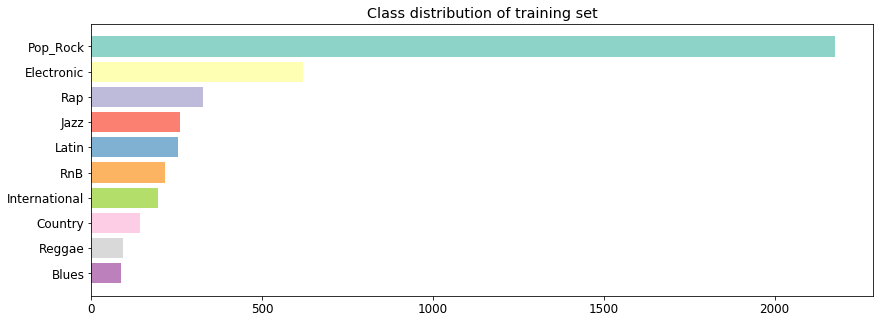

In [2]:
num_classes = 10
genres = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae', 'Blues']
class_counts = train_labels_df['class'].value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_classes)]
plt.barh(range(num_classes)[::-1], class_counts, tick_label=genres,
         color=colors)
plt.title('Class distribution of training set')
plt.show()

## Sufficient statistics

Plotting some **sufficient statistics (mean and standard deviation) of the features gives an idea of how informative each feature in each of the 3 given feature categories (rhythm, MFCC, and chroma patterns) would be**.

The plots were made using the mean of each feature taken here (24 features of mean and deviation for rhythm respectively and 12 for the mean and deviation of chroma and MFCC). Each dot represents the mean value of that corresponding feature (from 0 to 24 for rhythm or 0 to 12 for chroma and MFCC) for that corresponding label (represented as colours).

On the first 24 features the **mean rhythm** clearly shows how "pop rock" has a much higher rhythm than any other labels. Some smaller differences can be observed on the rhythm's standard deviations as well. For example, "blues" has a lower trend on "varying rhythms" than the other genres.

MFCC features, in contrast with the rhythm features, look extremely plain. Among each class (each colour), for each one feature, all the data seems to be homogenous. Not much emphasis has been put on this (since the model will learn to ignore these non-informative features), but it clearly shows that there is a whole lot of data tuning that can be done to get better results, before even considering different models.

Lastly, the chroma values seem to be somewhere in between the other two categories. The classes aren't easily distinguishable, but some very complex patterns may nevertheless be drawn from these.

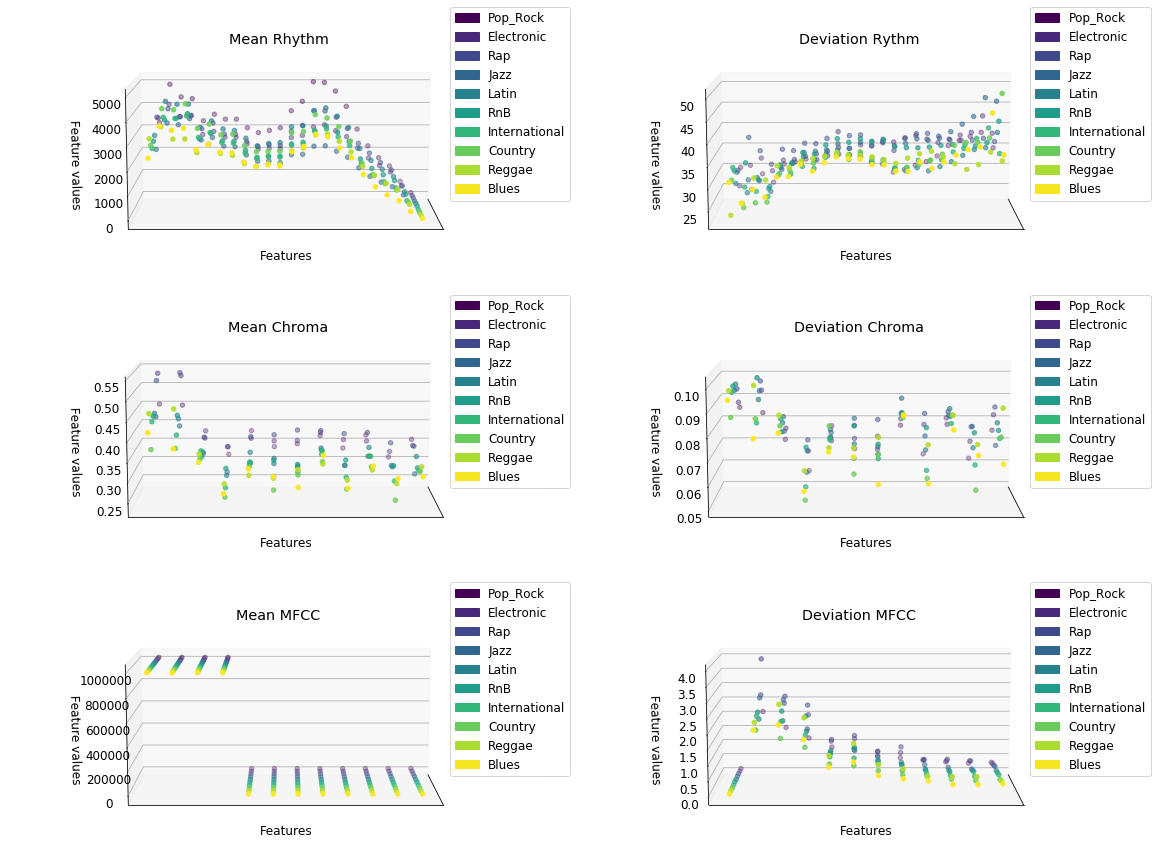

In [3]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

train_data = train_data_df.values
train_labels = train_labels_df.values
label_feature_means = []
for i in range(1,11):
    feature  = train_data[np.argwhere(train_labels == i)[:,0]]
    label_feature_means.append(np.mean(feature,axis=0))
label_feature_means = np.array(label_feature_means)
feature_indexes = np.array([[0,24],[48,72],[168,180],[180,192],[216,228],[228,240]])
graph_titles = ["Mean Rhythm","Deviation Rythm","Mean Chroma","Deviation Chroma","Mean MFCC","Deviation MFCC"]
plot_indexes = np.array([[0,3],[3,6],[0,3],[3,6],[0,3],[3,6]])
fig_size = plt.rcParams["figure.figsize"]
cmap = plt.cm.get_cmap(plt.cm.viridis, 10)
patches = []
for i in range(10):
    patches.append(mpatches.Patch(color=cmap(28*i),label=genres[i]))
fig_size[0] = 20
fig_size[1] = 15
gs = gridspec.GridSpec(3, 6)
gs.update(wspace=0.3)
fig = plt.figure()
for i in range(6):
    x = np.arange(0,10,1)
    y = np.arange(0,feature_indexes[i,1]-feature_indexes[i,0],1)
    c = np.array([np.repeat(i,len(y)) for i in x]).T
        
    ax=plt.subplot(gs[int(i/2),plot_indexes[i,0]:plot_indexes[i,1]],projection='3d')
    ax.set_title(graph_titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.view_init(elev=10,azim=0)
    xx, yy = np.meshgrid(x,y)
    ax.legend(handles=patches, loc=1, borderaxespad=-2)
    ax.set_ylabel("Features",labelpad=10)
    ax.set_zlabel("Feature values",labelpad=10)
    if i == 1:
        variance = label_feature_means[:,feature_indexes[i,0]:feature_indexes[i,1]]
        deviation = np.sqrt(variance)
        ax.scatter(xx,yy,deviation.T,c=c.flatten())
    else:
        ax.scatter(xx,yy,label_feature_means[:,feature_indexes[i,0]:feature_indexes[i,1]].T,c=c.flatten())
plt.show()



In [4]:
descriptive_stats = all_data_df.describe()

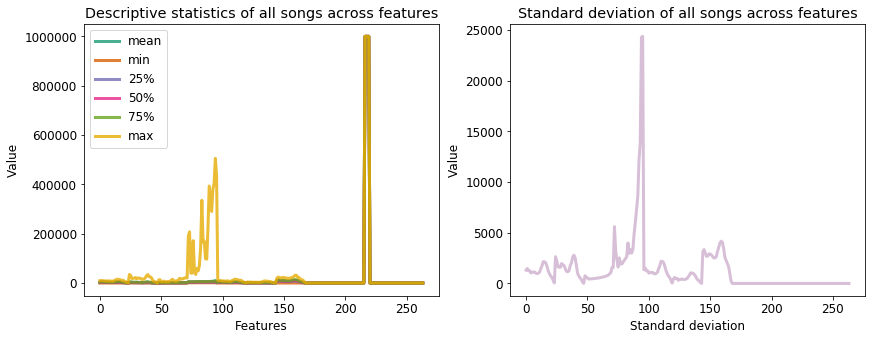

In [5]:
matplotlib.rcParams['figure.figsize'] = (14, 5)
tab10_cmap = plt.cm.get_cmap(plt.cm.Dark2, 10)
value_stats = ['mean', 'min', '25%', '50%', '75%', 'max']
plt.subplot(1, 2, 1)
for i, stat in enumerate(value_stats):
    plt.plot(descriptive_stats.loc[stat], label=stat, lw=3, alpha=0.8, color=tab10_cmap(i))
plt.ylabel("Value")
plt.xlabel("Features")
plt.legend()
plt.title("Descriptive statistics of all songs across features")

plt.subplot(1, 2, 2)
plt.plot(descriptive_stats.loc['std'], label=stat, lw=3, color='thistle')
plt.ylabel("Value")
plt.xlabel("Standard deviation")
plt.title("Standard deviation of all songs across features")

plt.show()

**Features 216-219** have huge mean, min, max, and quartiles of exactly 1,000,000 for both train and test sets: this is because these features are uniformly 1,000,000 for all songs, meaning that they are **completely uninformative features** and should be ignored by the training algorithm.

In [6]:
all_data_df.iloc[:, 216:220].T

,0,1,2,3,4,5,6,7,8,9,...,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543
216,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
217,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
218,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
219,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


Features 72-95, especially 72 and 88-95, also have very high max values compared to the 75th percentiles, which implies that **they have statistical outliers**. This is supported by the **unusually high variance** of features 72 and 88-95. Outliers will impede dimensionality reduction via PCA (see PCA section).

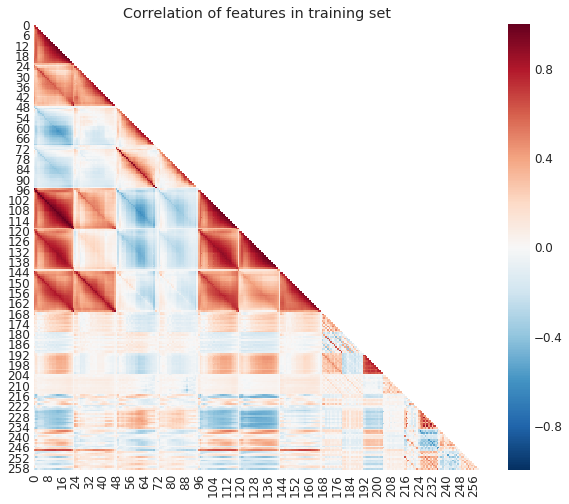

In [16]:
##### np.seterr(divide='ignore', invalid='ignore')
corr = np.corrcoef(train_data_df.T)
corr = np.nan_to_num(corr)  # Convert NaN's to zero
mask = np.zeros_like(corr)  # Mask out the upper triangle
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu_r", 
                square=True, cbar_kws={"shrink": .82})
plt.title("Correlation of features in training set")
plt.show()

The Pearson product-moment correlation coefficients of **all** the features in the training set is visualized in the matrix below. 

Red indicates a positive correlation and blue a negative correlation, while lighter shades mean the features are not correlated. We can see that **some features are uncorrelated with all other features**. For example, all 7 statistical descriptors of one of the 24 rhythm patterns is represented as the 7 thin horizontal and vertical white lines at the top of the triangle, and the completely uninformative features 216-219 in the MFCC features are seen as thicker white bands. 

If two features are highly correlated, we can **consider eliminating one of them as they might be redundant**. **Highly correlated features can also be problematic for some algorithms**, e.g. naive Bayes classifiers, which assume the features are independent given the class.


## Value distributions of features

From a visualization of the distributions of features, we can easily spot that some of the features are uniformly 1,000,000 (the blue horizontal line).

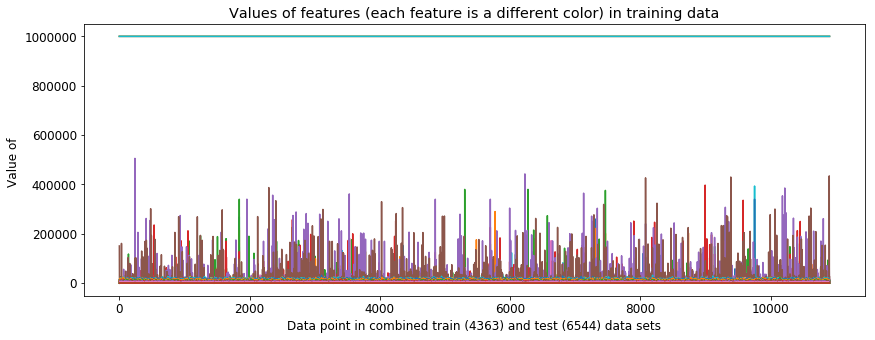

In [7]:
num_train_data, num_features = train_data_df.shape
indices = list(range(num_features))
for i in indices:
    plt.plot(all_data_df[i].values)
plt.xlabel("Data point in combined train (4363) and test (6544) data sets")
plt.ylabel("Value of ")
plt.title("Values of features (each feature is a different color) in training data")
plt.show()

In [8]:
del indices[216:220]  # Remove features 216-219 which have huge values

After removing the useless features, the plot improves. However, there are still visibly huge differences in the ranges of different features. For some machine learning algorithms such as SVM's, this is undesirable.

For each feature $x_i$ in each row of the input data, we rescale it such that its value is now between 0 and 1.
$$\dfrac{x_i – min(x)}{max(x) – min(x)}$$

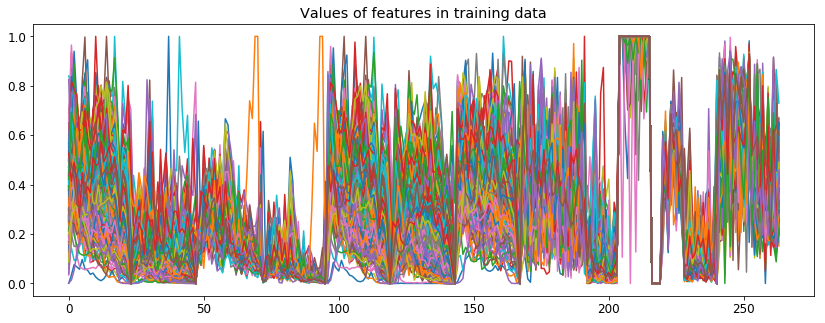

In [9]:
from sklearn import preprocessing
# Scale
min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(train_data_df)
del indices[216:220]
for i in indices:
    plt.plot(scaled_data[i])
plt.title("Values of features in training data")
plt.show()

Before scaling the features, the 3-D PCA projection is tightly clustered in the latent space.

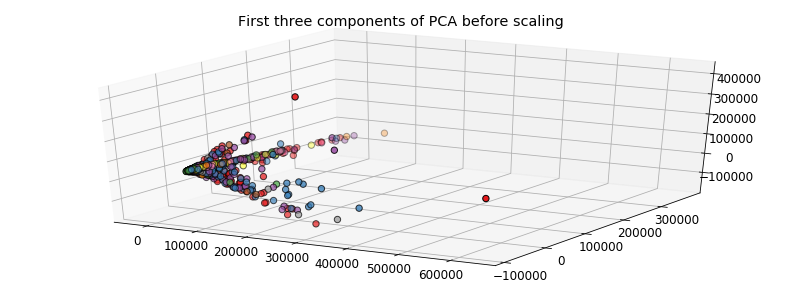

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(train_data_df)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA before scaling")

plt.show()

In [11]:
train_data_df = train_data_df.drop([216, 217, 218, 219], axis=1)
test_data_df = test_data_df.drop([216, 217, 218, 219], axis=1)

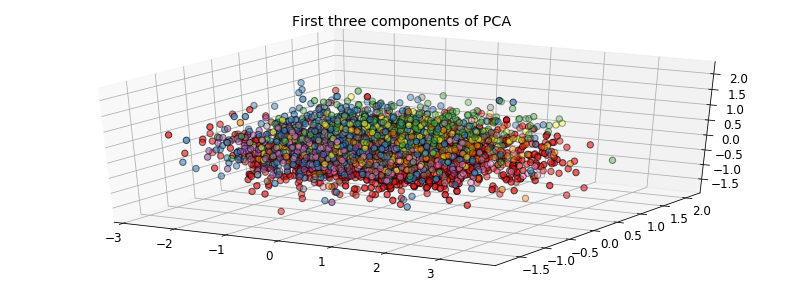

In [12]:
scaled_data = min_max_scaler.fit_transform(train_data_df)

pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(scaled_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA")

plt.show()

After min-max scaling the training data, the PCA visualization is much more distributed across the latent space, with relatively clearer regions for different classes, supporting the case for feature scaling.

# Methods and experiments

## Preprocessing
We use `MinMaxScaler` to scale all features, as mentioned in the previous section. 

A 70-30 split on the labeled training dataset is done in the beginning, and all the algorithms below are initially trained with the 70% training set and scored on both the training set and the 30% validation set. After tuning the hyperparameters with the validation set, the final models are then trained on 100% of the training set.

## 1. Neural network (NN)
Deep neural networks are known to **perform well, especially in supervised learning settings with large amounts of data**. This is because they are good at approximating very complex patterns.

Fully connected neural networks can be interpreted as matrix multiplication, addition with bias vectors, and activations. A general form would be $a_{l+1} = g(a_l * W_l + b_l)$, where $a_{l+1}$ is the output of the current calculated vector, $a_l$ the previous output, $W_l$ the weights matrix, $b_l$ is the bias, and $g$ is an activation function (the sigmoid $g(z)=\frac{1}{1+e^{-z}}$ is used here). The training is done using backpropagation to calculate the derivative of each parameter ($W_l, b_l$) with respect to the output, and sending these derivatives to a minimization function (Adam optimizer, in this case--a more complex form of gradient descent).

2- and 3-layer fully connected networks are trained.
- 2 layer model:
    - First layer: $264 \times 264$
    - Second layer: $264 \times 10$
- 3 layer model:
    - First layer: $264 \times 528$
    - Second layer: $528 \times 264$
    - Thrird layer: $264 \times 10$

## 2. Linear Support Vector Classifier (SVC)
The SVC is a good baseline for supervised classification with a small amount of data. A linear support vector machine (SVM) creates a hyperplane that uses support vectors to maximise the distance between the two classes. For this multiclass setting, **10 one-vs-rest classifiers are trained**. One minor implementation detail is that Sklearn's `LinearSVC` implementation regularizes the bias, unlike a conventional SVM.

To transform the vector of the 10 SVM's decision function outputs into a probability vector, we Platt’s sigmoid model [8].

## 3. Random Forest (RF)
Random Forest is a simple bagging algorithm with high predictive power that combines many decision tree classifiers. An individual decision tree has high variance, so **to reduce variance, the algorithm creates many different decision trees trained on resampled data**. It is also efficient as the training of the individual trees is parallelizable.

## 4. XGBoost (XGB)
Like RF, boosting gradient classifiers are also an ensemble technique using decision trees, but it is a boosting algorithm, while Random Forest is a bagging algorithm. Unlike bagging methods, **boosting methods are not parallelizable as the individual trees are sequentially added**. This is because after every iteration, the next predictor is fitted to the residuals of the previous prediction such that the errors of the previous model are corrected by the next tree. This helps to **reduce bias, on top of the already reduced variance** on account of combining many predictors.

In particular, **XGBoost is a well-known library** for its implementation accuracy and efficiency, well-formulated regularization parameters, Newton boosting, a randomisation parameter to reduce correlation between the trees, and other features.

## 5. Voting Ensemble
We take the algorithms that already inherit from Sklearn's `BaseEstimator`, and train a 'soft' voting classifier on two combinations: __XGB + RF__ and __XGB + RF + SVC__.

The voting classifier simply sums up the equally weighted probabilities of each classifier's prediction vector, and chooses the highest probability as the predicted class. This method works best when the individual classifiers are less correlated.


##  Evaluation methods

### Validation performance metrics
We **split the labeled training dataset into 30% validation set and keep the remaining 70% for training**. The validation metrics are used as an "offline" proxy for its "online" performance on unseen data, i.e. on the private Kaggle test sets.

This is useful for determining early stopping of training when the model is not improving anymore on the test set. For the best performing neural networks below, there is a clear point after which the test set accuracy is constant while the train set accuracy continues to climb, indicating overfitting.

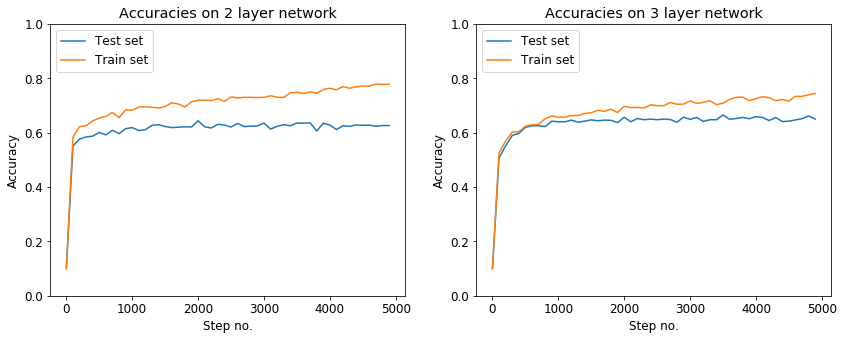

In [13]:
import analysis
hmaps = analysis.NN_heatmaps()
hmaps.accuracy_results()
indexes = np.linspace(0,49,50)*100
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(indexes,hmaps.test_accuracy_2L,label="Test set")
plt.plot(indexes,hmaps.train_accuracy_2L,label="Train set")
plt.legend(loc="upper left")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Step no.")
plt.title("Accuracies on 2 layer network")
plt.subplot(1, 2, 2)
plt.plot(indexes,hmaps.test_accuracy_3L,label="Test set")
plt.plot(indexes,hmaps.train_accuracy_3L,label="Train set")
plt.legend(loc="upper left")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Step no.")
plt.title("Accuracies on 3 layer network")
plt.show()



However, estimating the model's performance with a held-out validation set has a high variance due to differences in the training and validation sets.

### Cross-validation for performance metrics
For the algorithms that are faster to train, we also use a *better (lower variance) but more computationally expensive* benchmark: **stratified k-fold cross validation**. We split the training set into $k$ folds, where the algorithm is run $k$ times on $k-1$ folds and tested on the held-back fold; each fold of the dataset is held back once. We use $k=3$, similar to how we did a 30-70 split when computing the traditional validation metrics.

Since our data has a class imbalance, we use **stratified folds** which enforce the same distribution of classes in each fold as in the whole training dataset.

**This metric had a better correlation with the Kaggle performance**. There were several cases where the validation accuracy and log-loss looked promisingly high but the cross-validated scores were more realistic and indicative of its online performance. The inverse is also possible. For example, the ensemble of XGBoost and RandomForest /performed well on Kaggle (65.4%) and also had high cross-validation scores (62.7%), but the performance metrics on the validation set were unusually low/, with an accuracy of 51.9%. The confusion matrix also looked poor, with most of the validation data being labeled as pop rock (class 0), and a very low ROC AUC at 0.654 (weighted) and 0.625 (macro).

![ensemble-xgb-rf cm](img/cm_ensemble_rf_xgb.png)


### Confusion matrix
Each row of the confusion matrix represents the number of instances predicted to be a particular class, while each column represents the number of instances that actually belong to that class.

Below is the confusion matrix for the best-performing 2 layer NN on the held-out validation set. As expected, **the first class (pop rock) is the predominant misclassification**, since pop rock is the majority class by far.

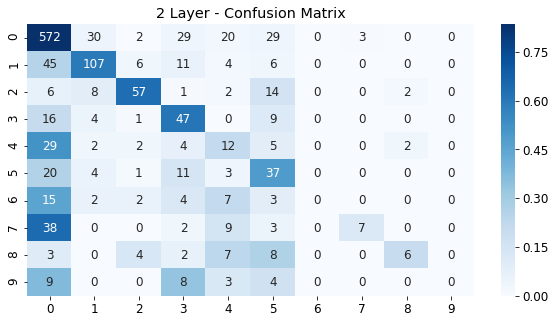

In [14]:
hmaps.conf_matrix()
def get_proportions(confusion_values):
    props = []
    for i in range(10):
        props.append(confusion_values[i,:]/np.sum(confusion_values[i,:]))
    return props
proportions_2L = get_proportions(hmaps.conf_matrix_2L)
plt.figure(figsize=(10,5))
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("2 Layer - Confusion Matrix")
sns.heatmap(proportions_2L,cmap="Blues",annot=hmaps.conf_matrix_2L, fmt=".0f")
plt.show()


### Area Under the Received Operating Characteristic Curve (ROC AUC)
This is **a proxy for the quality of the confusion matrix**. We compute both the `weighted` and `macro` averaging of the ROC AUC scores for each class on the validation set.

- The `weighted` averaging of AUC scores will weight each class to **preserve to the original class imbalance**.

- To see the performance **if all clases were uniform**, we can look at the `macro` averaging which gives all classes the same weight.

## Tuning hyperparameters with grid search
### Neural network
The 2-layer and 3-layer models were trained on every combination of the following hyperparameters:
- Dropout: $[0.3, 0.2, 0.15, 0.1, 0.05]$
- Learning rate: $[0.001, 0.003, 0.005, 0.01, 0.03]$

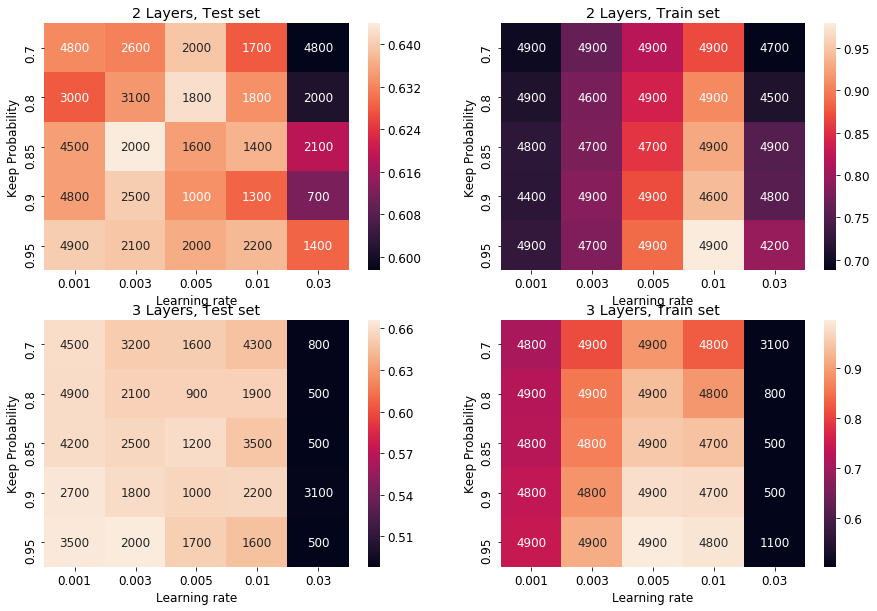

In [15]:
hmaps.hmaps()
hmaps.convert_numpy()
hmaps.accuracy_results()
learning_rate_ = [0.001, 0.003, 0.005, 0.01, 0.03]
keep_prob_ = [0.7, 0.8, 0.85, 0.9, 0.95]

matplotlib.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2, 2, 1)
steps_2_test = hmaps.heat_map_2_test_steps[:5,:]
sns.heatmap(hmaps.heat_map_2_test[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
           annot=steps_2_test, fmt="d")
plt.title("2 Layers, Test set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 2)

sns.heatmap(hmaps.heat_map_2_train[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
           annot=hmaps.heat_map_2_train_steps[:5,:], fmt="d")
plt.title("2 Layers, Train set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 3)

sns.heatmap(hmaps.heat_map_3_test[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
            annot=hmaps.heat_map_3_test_steps[:5,:], fmt="d")
plt.title("3 Layers, Test set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 4)

sns.heatmap(hmaps.heat_map_3_train[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
            annot=hmaps.heat_map_3_train_steps[:5,:], fmt="d")
plt.title("3 Layers, Train set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.show()
plt.tight_layout()
plt.subplots_adjust(hspace=-3)

The **color of each grid in the heatmap represents the validation accuracy**, and the **printed numbers represent the step size at which the accuracy was maximum**--that is, the point at which the model starts to overfit.

The train accuracy continues to improve from the point where the test accuracy stopped improving, showing that **further training actually means overfitting**. Both the 2-layer and 3-layer's train accuracy have max around 5000 steps (the maximum number of iterations) with the exception of learning_rate=0.03 on 3-layer net which does not seem like it can converge, and are mostly black squares.

The rest of the black squares suggest either that the model has not converged, or is unable to converge because of setting dropout rate too high, because they trained until the maximum number of iterations.

For each type (2-layer or 3-layer), the best parameters were:
- 2-layer: keep_probability=0.85 (equivalent to dropout 0.15) and learning_rate= 0.003, trained for 2000 steps
- 3-layer: keep_probability=0.95 (equivalent to dropout 0.05) and learning_rate= 0.001, trained for 3500 steps

## Linear SVC
As LinearSVC is a fast algorithm, a grid search was done on its hyperparameters as well, namely on the regularization function (L1 or L2 loss) and the value of the penalty parameter $C$.

![search](img/gridsearch_LinearSVC.png)

Although all the accuracies are very close, **L1 loss gave higher accuracies** for $C \in [1, 5, 10, 15, 50, 100, 1000]$. This is possibly because the L1 penalty works better on sparse data, and our data does not have a high proportion of informative features.

The effect of $C$ in relation to the risk minimization function,
$$C \sum_{i=1, n} \mathcal{L} (f(x_i), y_i) + \Omega (w)$$

is that $C$ determines how much the model cares about classification error $\mathcal{L}$ as opposed to $\Omega$, the penalty function (L1 or L2) regularizing the model parameters. If $C$ is high, the optimization will result in a smaller-margin separating hyperplane if that classifies more training points correctly. If $C$ is low, a larger-margin hyperplane will be prioritized over classification accuracy. For L1 loss, **the best $C$ value is neither too high nor too low, at $C=[5, 10]$**.

The best parameters were L1 loss and $C=5$.

# Results

## Experimental outcomes

The "offline" log-loss and accuracy are computed with stratified K-fold cross-validation on the faster algorithms, and computed directly on the validation set for the neural networks. Only the models with the best "offline" performances are chosen to be scored "online" on Kaggle.

For `final` models, there is no splitting between validation and test sets and they are trained with 100% of the training data. Since we compute AUC on the validation set, the AUC score cannot be computed on the `final` models.

`S` indicates that the data was min-max scaled, and `D` indicates that the uninformative features 216-219 were dropped.

| Model                         | Log-loss [s.d.]    | Accuracy [s.d.]    | AUC (weighted/macro) | Kaggle (L-L) | Kaggle (Acc.) |
|-------------------------------|--------------------|--------------------|----------------------|--------------|---------------|
| XGBoost                       | 1.10483 [0.031224] | 0.64055 [0.01678]  | 0.87161/0.86431      |      0.17474 |       0.64798 |
| XGBoost (S)                   | 1.11093 [0.034256] | 0.63661 [0.017100] | 0.87104/0.86205      |              |               |
| XGBoost (S, D)                | 1.12689 [0.02131]  | 0.63196 [0.00806]  | 0.87152/0.86687      |              |               |
| random forest                 | 1.26570 [0.00887]  | 0.58742 [0.00146]  | 0.85220/0.84101     |              |               |
| random forest (S)             | 1.25397 [0.01027]  | 0.60622 [0.00972]  | 0.99831/0.99956     |      0.19964 |       0.60163 |
| random forest (S, D)          | 1.25178 [0.02163]  | 0.59497 [0.00607]  | 0.85150/0.84345      |              |               |
| random forest (balanced)      | 1.36745 [0.02399]  | 0.59300 [0.00134]  | 0.84223/0.82973      |              |               |
| linearSVC                     | 1.21057 [0.63713]  | 0.59366 [0.00369]  | 0.84733/0.82310      |              |               |
| linearSVC (S)                 | 1.13869 [0.01445]  | 0.64013 [0.00716]  | 0.86487/0.85752      |      0.19221 |       0.61487 |
| linearSVC (S, D)              | 1.13972 [0.01345]  | 0.63817 [0.00583]  | 0.86474/0.85722      |              |               |
| **final** XGBoost             | 1.09515 [0.00780]  | 0.65460 [0.00425]  | -                    |      **0.17077** |       **0.66225** |
| **final** random forest (S)   | 1.35585 [0.02808]  | 0.60577 [0.00487]  | -                    |            0.21831 |             0.57208 |
| **final** linearSVC (S)       | 1.16738 [0.01001]  | 0.64130 [0.00309]  | -                    |            0.22089 |             0.52419 |
| **final** neural network (2-layer)    | 0.23542 \* \*\*         | 0.64400 **         | -                    |      0.23639 |       0.62913 |
| **final** neural network (3-layer)    | 0.24244 \* \*\*         | 0.66539 **         | -                    |       0.2499 |       0.59093 |
|-------------------------------|--------------------|--------------------|----------------------|--------------|---------------|
| voting ensemble (XGB, RF)            | 1.14183 [0.01128]  | 0.62737 [0.00150]  | 0.65397/0.62538      |      0.17287 |       0.65359 |
| voting ensemble (unfitted XGB, RF)   | 1.16674 [0.00728]  | 0.63523 [0.00491]  | 0.87064/0.86256      |              |               |
| **final** voting  ensemble (final XGB, RF)  | 1.14325 [0.00340]  | 0.65482 [0.00234]  | -                   |     0.17773 | 0.65664  |
| voting ensemble (XGB, RF, SVC)       | 1.14984 [0.00764]  | 0.62344 [0.00535]  | 0.87358/0.86394      |              |               |
| **final** voting ensemble (final XGB, RF, SVC) | 1.13104 [0.00655]  | 0.65505 [0.00686]  | -                    |      0.17544 |       0.66123 |

\* computed with `tf.losses.log_loss` (instead of `sklearn.metrics.log_loss`)

\** scored on held-out validation set



# Discussion

## Pitfalls of evaluation metrics
### Accuracy
Accuracy **can be highly misleading** on an imbalanced dataset. If the majority class is large, simply guessing the majority class yields a highly accurate classifier.

### Log-loss
While accuracy only cares about the class with the highest probability, log-loss penalizes predictions differently according to its confidence levels. A misprediction with a high confidence will be penalized much more than a misprediction with a lower confidence. Therefore, **log-loss is a more informative indicator of a classifier's performance, as well as a better objective function for optimizing an algorithm**.

However, if we care about predicting some classes accurately more than other classes, then log-loss is not a good metric as log-loss treats them equally. In this case, other metrics would be precision-recall, ROC-AUC, F-scores, and confusion matrices.

## Evaluation of results
The **2-layer network had a higher accuracy than the 3 layer network**. Deep learning networks work extremely well for large amounts of data, but are prone to overfitting when the dataset is small such as in this case, so the simpler model was able to generalize a bit better, even though the top accuracies for the "offline" case belong to the 3 layer model.

Tuning the dropout and learning rate hyperparameters, along with early stopping in the training, were important in getting models that could generalize decently well and get a maximum "online" accuracy of 62.9%.

The SVC did not have the best performance because it uses a linear kernel for the support vector machines, but **the data is unlikely to be linearly separable** in this task. Furthermore, SVM's fundamentally do not model uncertainty using probabilities, so their output scores are not comparable across classes, and SVC's cannot achieve the highest log-loss.

Random Forest performed the worst, possibly because bagging method does not reduce bias. From the visualization of feature importances, the trained Random Forest classifier only focused on a small percentage of the features.

![](img/feature_importances_Random Forest.png)

In comparison, **XGBoost, which yields the best performance, has a different feature importance visualization**. XGBoost prioritizes the features more uniformly, which seems to be a better approach as far as the metrics show.

![](img/feature_importances_XGBoost.png)

XGBoost's success is unsurprising given its high performance in many data science competitions, and can be attributed to its high robustness to outliers and predictive power.

The voting classifiers performed better on average than any single classifier, except for XGBoost. A voting classifier is a heterogenous ensemble that **reduces variance by aggregating the predictions of multiple classifiers alone, resulting in better generalization**.

The results obtained here cannot be directly compared to that of other approaches in this specific task, since the datasets are different.




## Impact of feature engineering
**Dropping the uninformative features (216-219) did not impact any of the classifiers**, meaning that the chosen models are robust to such flaws in the data. The feature importance graphs of Random Forest and XGBoost shows that they ignored the uninformative features perfectly.

However, **scaling does slightly improve Random Forest**. **Scaling also improves SVC more drastically** by around 4.5% in accuracy and 0.0726 in log-loss. It is important to scale the input features before training an SVM, because SVM's will prioritize features of higher order of magnitude over lower magnitude features.

**Both scaling and dropping features did not improve XGBoost performance** and even degrades it very slightly; this is likely because XGBoost has automatic feature selection and learns to ignore outliers and uninformative features. 

## Balancing the classes
Giving each class weights inversely proportional to class frequencies did not boost any metrics. Having **a balanced random forest classifier even degrades the metrics slightly**, dropping log-loss by 0.01 and accuracy by 1%. Using **a balanced SVC degrades it far more** with accuracy drops of around 10%, since an SVM will prioritize values of higher magnitude.

## Suggestions for future research/improvement.

### Ensemble methods
Adding more estimators to the voting classifier, such as neural networks, and other classifiers not explored here, would improve the voting classifier. It would also be helpful to evaluate the correlation of the individual estimators and experiment with different combinations of them.

Other than the voting classifier model, other ensemble methods like Adaboost classifier are areas for exploration as well.

### Further hyperparameter tuning
While the hyperparameters for SVC and neural networks were tuned with grid search, the XGBoost and Random Forest classifiers were not. Further finetuning will very likely improve results[9].

### Hyperparameter tuning methods
Many better methods for tuning model hyperparameters exist. The naive way used here is exhaustive grid search, but alternatives include randomized grid search, Bayesian optimization[10], evolutionary algorithms [11], and more [12, 13].

### Better data representation
The feature extraction from the songs' raw acoustic signals was poor here, e.g. the 4 corrupted features. Experimenting with different representations of the song data would be worthwhile, if the original song data were available.

# References
[1] Haggblade, M., Hong, Y., & Kao, K. (2011). Music Genre Classification.

[2] Goulart, A., Guido, R., Maciel, C.: Exploring different approaches for music genre classification. Egypt. Inf. J. 13(2), 59–63 (2012)

[3]  Carlos Nascimento Silla Jr., Alessandro L. Koerich, Celso A. A. Kaestner: A Machine
Learning Approach to Automatic Music Genre Classification. J. Braz. Comp. Soc.
14(3): 7-18 (2008).

[4] Gunn, Steve R. "Support vector machines for classification and regression." ISIS
technical report 14.1 (1998): 5-16.

[5]  J. Irvin, E. Chartock, N. Hollander, “Recurrent Neural Network with Attention for
Genre Classification”, 2016

[6] Lonce Wyse. 2017. Audio spectrogram representations for processing with convolutional neural networks. arXiv preprint arXiv:1706.09559.

[7] George Tzanetakis and Perry Cook. 2002. Musical genre classification of audio signals. IEEE Transactions on speech and audio processing 10(5):293–302.


[8] Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods, J. Platt, (1999)

[9] Félix Revert. (2018). Fine-tuning XGBoost in Python like a boss. https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

[10] https://github.com/hyperopt/hyperopt

[11] https://github.com/EpistasisLab/tpot

[12] https://github.com/reiinakano/xcessiv

[13] https://github.com/automl/auto-sklearn

# Appendix

Refer to `readme.txt` for instructions on installation and running the code.
